### EV charging simualtion - dumb 
#### EV charges when EV at home, doesn't consider PV or BS

In [2]:
import pandas as pd
import numpy as np

# Constants and EV specifications
year = 2016
hours_per_year = 8784
car_efficiency = 191 / 1000  # kWh per km
battery_capacity = 72  # kWh
battery_min = 10  # %
battery_max = 80  # %
min_battery_level = battery_min / 100 * battery_capacity  # kWh
max_battery_level = battery_max / 100 * battery_capacity  # kWh
max_charge_power = 11  # kW

# Results DataFrame setup
results = pd.DataFrame(index=pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='h'), 
                       columns=['EV_battery', 'EV_at_home', 'Grid_used', 'Energy_used_total'])

def simulate_ev_charging_dumb(homeoffice=True):
    # Load the pre-saved car availability profile with distance traveled based on the homeoffice setting
    profile_name = f'C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\car_availability_homeoffice_{homeoffice}.csv'
    profile_data = pd.read_csv(profile_name, index_col=0)
    car_availability = profile_data['EV_at_home'].values
    distance_travelled = profile_data['distance_travelled'].values

    # Initial conditions
    ev_battery = max_battery_level

    for hour in range(hours_per_year):
        grid_used_total = 0

        # Driving consumption logic: Deduct battery consumption based on precomputed distance
        trip_distance = distance_travelled[hour]
        if car_availability[hour] == 0 and trip_distance > 0:
            # Calculate required battery for the trip
            required_battery = trip_distance * car_efficiency
            if ev_battery - required_battery >= min_battery_level:
                ev_battery -= required_battery
            else:
                # If not enough battery for the full trip, reduce distance proportionally
                trip_distance = (ev_battery - min_battery_level) / car_efficiency
                ev_battery = min_battery_level  # Battery depletes to minimum level only

        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Charge from the grid up to the maximum battery capacity
            charge_power = min(max_charge_power, max_battery_level - ev_battery)
            ev_battery += charge_power
            grid_used_total += charge_power

        # Calculate total energy used for charging the EV this hour
        energy_used_total = grid_used_total

        # Update results
        results.loc[results.index[hour], 'EV_battery'] = ev_battery
        results.loc[results.index[hour], 'EV_at_home'] = car_availability[hour]
        results.loc[results.index[hour], 'Grid_used'] = grid_used_total
        results.loc[results.index[hour], 'Energy_used_total'] = energy_used_total

    return results


#### Homeoffice = True

In [3]:
res = simulate_ev_charging_dumb(homeoffice=True)
grid = sum(res['Grid_used'])
energy = sum(res['Energy_used_total'])
home = sum(res['EV_at_home'])

print('Grid: ', grid)
print('Energy used total: ', energy)
print('EV at home: ', home)
print('EV not at home: ', hours_per_year-home)

Grid:  1943.233999999999
Energy used total:  1943.233999999999
EV at home:  7654.0
EV not at home:  1130.0


<function matplotlib.pyplot.show(close=None, block=None)>

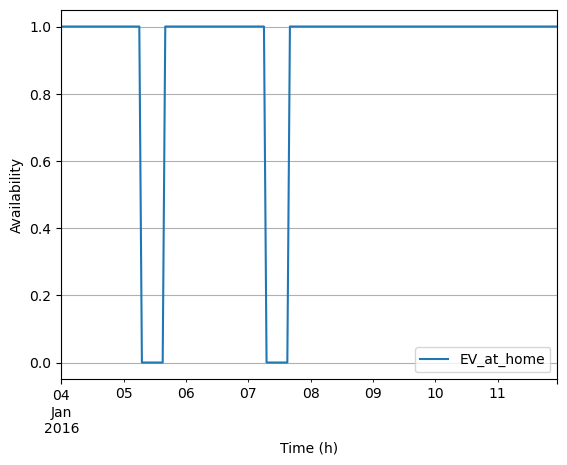

In [4]:
import matplotlib.pyplot as plt 

tag = res.loc['2016-01-04 00:00:00':'2016-01-11 23:00:00', ['EV_at_home']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Availability')
plt.grid(True)
plt.show

#### Homeoffice = False

In [5]:
res_f = simulate_ev_charging_dumb(homeoffice=False)
grid = sum(res_f['Grid_used'])
energy = sum(res_f['Energy_used_total'])
home = sum(res_f['EV_at_home'])

print('Grid: ', grid)
print('Energy used total: ', energy)
print('EV at home: ', home)
print('EV not at home: ', hours_per_year-home)

Grid:  3392.541999999999
Energy used total:  3392.541999999999
EV at home:  6217.0
EV not at home:  2567.0


<function matplotlib.pyplot.show(close=None, block=None)>

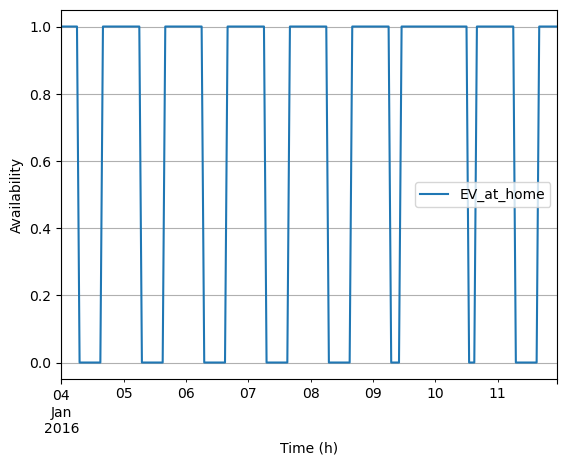

In [6]:
import matplotlib.pyplot as plt 

tag = res_f.loc['2016-01-04 00:00:00':'2016-01-11 23:00:00', ['EV_at_home']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Availability')
plt.grid(True)
plt.show

In [7]:
profile_name = f'C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\car_availability_homeoffice_False.csv'
profile_data = pd.read_csv(profile_name, index_col=0)
car_availability = profile_data['EV_at_home'].values
distance_travelled = profile_data['distance_travelled'].values
x = sum(profile_data['distance_travelled'])

profile_name = f'C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\car_availability_homeoffice_True.csv'
profile_data = pd.read_csv(profile_name, index_col=0)
car_availability = profile_data['EV_at_home'].values
distance_travelled = profile_data['distance_travelled'].values
x1 = sum(profile_data['distance_travelled'])

print('Distance (False): ', x)
print('Distance (True): ', x1)

Distance (False):  17762.0
Distance (True):  10174.0


<function matplotlib.pyplot.show(close=None, block=None)>

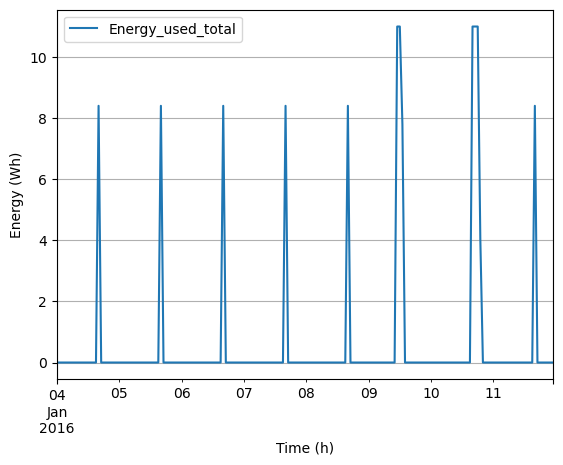

In [ ]:

tag = res.loc['2016-01-04 00:00:00':'2016-01-11 23:00:00', ['Energy_used_total']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Energy (kWh)')
plt.grid(True)
plt.show

Save to CSV

In [9]:
res.to_csv('ev_dumm_true.csv')
res_f.to_csv('ev_dumm_false.csv')